# Tutorial: Representative Analysis

## Introduction

For this example, we are interested in understanding how representative (i.e., possible similarities and differences) a subset corpus is of the global corpus. The global corpus captures information about newspaper content collected from around the world during May 19-Jun 11, 2019. In contrast, the subset corpus contains only information about articles that were extracted (from the global corpus) using machine learning for a particular topic. Both the global and subset corpus datasets contain a count of the number of articles present for a given country and language on a particular date of publication.

In [15]:
import os, sys
import pyrocs.biosciences as pyrocs_bio
import pyrocs.information_theory as pyrocs_info
import pyrocs.complex_systems as pyrocs_cmpx
import pandas as pd
import numpy as np

df = pd.read_csv("exemplar_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
print("Imported Data:", df, sep="\n")

Imported Data:
            Category       Date    Language  Country  Count
0       whole_corpus 2019-05-31   Afrikaans    Italy      1
1       whole_corpus 2019-06-07   Afrikaans    Italy      1
2       whole_corpus 2019-06-11   Afrikaans    Italy      1
3       whole_corpus 2019-05-20   Afrikaans  Namibia      7
4       whole_corpus 2019-05-21   Afrikaans  Namibia      4
...              ...        ...         ...      ...    ...
11873  subset_corpus 2019-06-08  Vietnamese  Vietnam     15
11874  subset_corpus 2019-06-09  Vietnamese  Vietnam      9
11875  subset_corpus 2019-06-10  Vietnamese  Vietnam      8
11876  subset_corpus 2019-06-11  Vietnamese  Vietnam      3
11877  subset_corpus 2019-06-12  Vietnamese  Vietnam      1

[11878 rows x 5 columns]


This data has the following columns:
- Category: Whether the count represents the entire corpus (whole_corpus), or the subset of interest (subset_corpus)
- Date: Date article was published
- Language: Language of news article
- Country: URL country of origin
- Count: Number of news articles with the given Category, Date, Language, and Country of origin

## Basic Analysis

To understand differences between the whole corpus and the subset, we begin with comparing summary statistics. We first seperate the whole_corpus, and subset_corpus data into seperate dataframes. Then, we generate a statistic summarizing the total number of articles within each category.

In [16]:
whole_corpus_df = df[df["Category"] == "whole_corpus"].drop("Category", axis=1)
subset_corpus_df = df[df["Category"] == "subset_corpus"].drop("Category", axis=1)

print("Number of articles in each corpus")
print("Whole Corpus:", whole_corpus_df["Count"].sum())
print("Subset Corpus:", subset_corpus_df["Count"].sum())

#print("Whole corpus data:", whole_corpus_df, sep="\n")
#print("\n\nSubset corpus data:", subset_corpus_df, sep="\n")

Number of articles in each corpus
Whole Corpus: 3356317
Subset Corpus: 5488


We can also generate counts by Country of Origin, which will serve as the basis for the rest of analysis in this notebook. Similar approaches could be applied to the Language field depending on the analyst's interests.

In [17]:
def group_by_fields(data, *fields, reset_index=False):
    result = data[["Count", *fields]].groupby(list(fields)).sum()
    if reset_index:
        result.reset_index(inplace=True)
    return result

whole_corpus_countries = group_by_fields(whole_corpus_df, "Country")
subset_corpus_countries = group_by_fields(subset_corpus_df, "Country")
#print("Number of articles grouped by country of origin, for the")
#print("\nWhole corpus:", whole_corpus_countries.head(), "...", sep="\n")
#print("\nSubset corpus:", subset_corpus_countries.head(), "...", sep="\n")

num_whole_corpus_countries = len(whole_corpus_countries)
num_subset_corpus_countries = len(subset_corpus_countries)
print("Number of distinct countries in the")
print("Whole corpus:", num_whole_corpus_countries)
print("Subset corpus:", num_subset_corpus_countries)

relative_country_diff = (num_whole_corpus_countries - num_subset_corpus_countries) / num_whole_corpus_countries
print("The whole corpus has {:.1%} more countries than the subset corpus".format(relative_country_diff))

Number of distinct countries in the
Whole corpus: 171
Subset corpus: 107
The whole corpus has 37.4% more countries than the subset corpus


The most frequent countries from the whole and subset corpora can be visualized using bar graphs and pie charts:

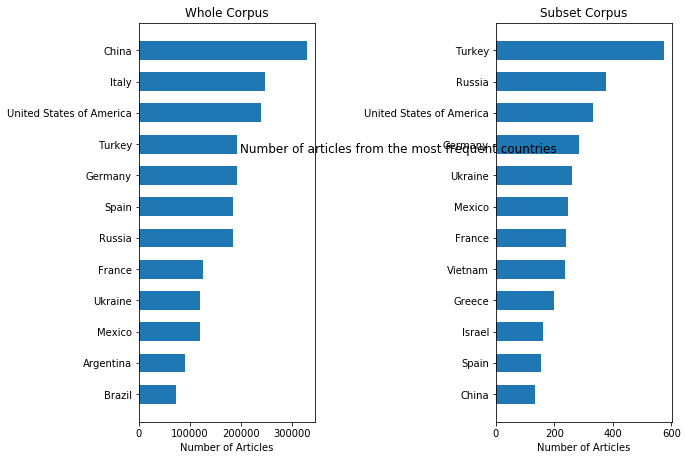

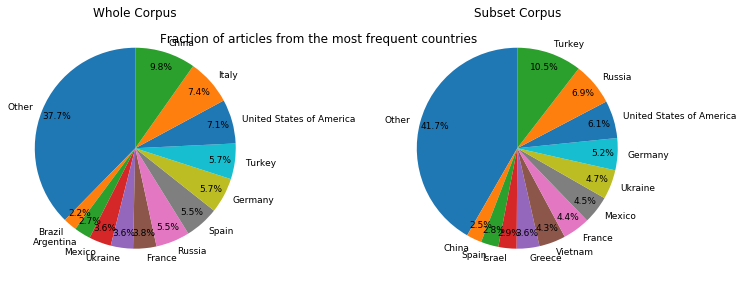

In [18]:
import matplotlib.pyplot as plt

def set_hbar(head, title, ax):
    ax.barh(head.index, head["Count"], height=.6)
    ax.invert_yaxis()
    ax.set_xlabel("Number of Articles")
    ax.set_title(title)

def set_pie(head, data, title, ax):
    remainder = data["Count"].sum() - head["Count"].sum()
    head = head.copy()
    head.loc["Other"] = {"Count": remainder}
    head = head.loc[::-1]
    ax.pie(head["Count"], labels=head.index, startangle=90, textprops={'fontsize': 9}, autopct="%1.1f%%", pctdistance=.85)
    ax.set_title(title)
    
head_size = 12
whole_corpus_countries.sort_values("Count", ascending=False, inplace=True)
whole_countries_head = whole_corpus_countries.head(head_size)
subset_corpus_countries.sort_values("Count", ascending=False, inplace=True)
subset_countries_head = subset_corpus_countries.head(head_size)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))
fig.suptitle('Number of articles from the most frequent countries', y=.62)
fig.tight_layout(pad=15)
set_hbar(whole_countries_head, "Whole Corpus", ax1)
set_hbar(subset_countries_head, "Subset Corpus", ax2)
plt.show()

print("\n")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))
fig.suptitle('Fraction of articles from the most frequent countries', y=.67)
fig.tight_layout(pad=10)
set_pie(whole_countries_head, whole_corpus_countries, "Whole Corpus", ax1)
set_pie(subset_countries_head, subset_corpus_countries, "Subset Corpus", ax2)
plt.show()

In addition to these summaries, we can also look at the number of articles for the whole and subset corpuses across dates (in the timeframe of interest).

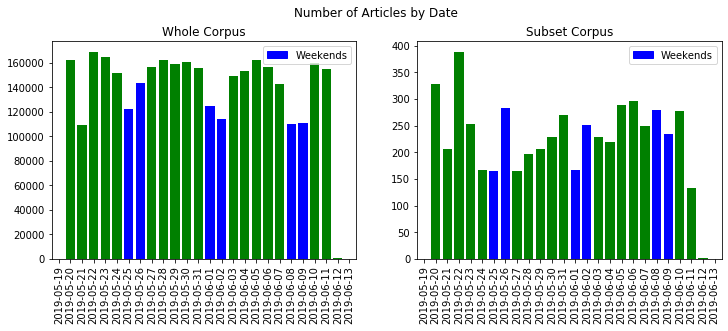

In [19]:
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

def set_time_bar(data, title, ax):
    date_data = group_by_fields(data, "Date")
    date_data.reset_index(inplace=True)
    date_data["DayOfWeek"] = date_data["Date"].dt.strftime("%A")
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    colors = date_data["DayOfWeek"].apply(
        lambda x: "blue" if x in ["Saturday", "Sunday"] else "green"
    )
    ax.bar(data=date_data, x="Date", height="Count", color=colors)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.legend(handles=[
        mpatches.Patch(color='blue', label='Weekends')
    ])
    ax.set_title(title)
    ax.tick_params('x', labelrotation=90)
    
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Number of Articles by Date', y=1)
set_time_bar(whole_corpus_df, "Whole Corpus", ax1)
set_time_bar(subset_corpus_df, "Subset Corpus", ax2)
plt.show()

These visual summaries of the two datasets provide some initial qualitative insights across the datasets (for ex, we can see that the subset corpus is much less regular, is more heavily weighted toward weekends, and may be bimodal in the above time plot), while summary statistics can provide some numbers for specific features of the data. 

To understand patterns across the two datasets as a whole, however, we need to leverage the metrics in pyRoCS. 

## Quantified Comparisons using pyRoCS

### Diversity Metrics
One of the simplest measures in pyRocs involves understanding the relative diversity between two datasets. The basic analysis above indicates that that the whole corpus has more countries than the subset corpus. However, the visualizations of top countries indicate that the concentration of articles in the most frequent countries is similar between the subset and whole corpus. To quantify this we can use three of the pyRoCS diversity metrics:
- Shannon Entropy (or just Entropy for short)
- Hill-Simpson
- Hill-Shannon

**Shannon entropy** specifically reflects the uncertainty in being able to know the details of a randomly selected individual from the population – which can then be used as a measure of the diversity of the population.  In our example, this would be the uncertainty of knowing the country of origin of any randomly selected article.

In contrast, the **Hill-Simpson** and **Hill-Shannon** metrics are part of a family of metrics which measure the "effective" number of values to consider how common or rare individuals with the same details are within the population. These can be weighted to better understand the most common or abundant type (Hill-Shannon) as compared to the rarest (Hill-Simpson). In our case, we focus on the uniqueness or commonness of the country of origin across the full dataset.

In [20]:
from scipy.stats import entropy

def get_diversity_metrics(data):
    normalized = data["Count"] / data["Count"].sum()
    array = normalized.to_numpy(dtype=float)
    
    return {
        "Entropy": pyrocs_info.entropy(array, base=2),
        "Hill-Simpson": pyrocs_bio.hill_simpson(array),
        "Hill-Shannon": pyrocs_bio.hill_shannon(array)
    }

whole_corpus_countries_diversity = get_diversity_metrics(whole_corpus_countries)
subset_corpus_countries_diversity = get_diversity_metrics(subset_corpus_countries)
diversity_df = pd.DataFrame(
    [whole_corpus_countries_diversity, subset_corpus_countries_diversity],
    ["Whole Corpus", "Subset Corpus"]
)
print(diversity_df)

                Entropy  Hill-Simpson  Hill-Shannon
Whole Corpus   5.318379     24.206543     39.901728
Subset Corpus  5.412542     26.510024     42.592939


The diversity metrics indicate that despite the whole corpus having more distinct countries, that the whole and subset corpora are very similar. This is, in part, because the additional countries in the whole corpus make up a very small portion of the total article counts. The marginally higher values across the diversity metrics for the subset corpus indicates that this corpus is actually more evenly distributed (i.e., less rare countries and fewer countries with a high frequency) across the countries.

### KL-Divergence

To quantify the difference between distributions in a single number we use the **Kullback-Leibler (KL) Divergence**. This divergence makes sense for comparing a sample distribution of countries, like the subset corpus, drawn from a reference distribution (i.e., the whole corpus). Lower values indicate higher similarities between the two distributions.

In [21]:
def make_distributions(reference, sample):
    """Takes two Dataframes and returns two distributions as normalized numpy arrays"""
    reference_distr = reference["Count"].to_numpy(dtype=float)
    sample_distr = reference.index.map(
        lambda x: sample["Count"].get(x, 0)
    ).to_numpy(dtype=float)
    reference_distr = reference_distr / reference_distr.sum()
    sample_distr = sample_distr / sample_distr.sum()
    return reference_distr, sample_distr

whole_country_distr, subset_country_distr = make_distributions(whole_corpus_countries, subset_corpus_countries)
kl_div = pyrocs_info.kl_divergence(subset_country_distr, whole_country_distr)
print("KL Divergence (of the country distribution) between the whole and subset corpus: {0:.3f}".format(kl_div))
print("2^(KL Divergence): {0:.3f}".format(2**kl_div))

KL Divergence (of the country distribution) between the whole and subset corpus: 0.683
2^(KL Divergence): 1.606


The KLD is about 0.68, which indicates high similarity between the two distributions. Since KLD is equivalent to the mean log-base-2 ratio, we can raise 2 to the power of the KLD to estimate the relative frequencies of common countries between the two distributions. The above example indicates that the most common countries in the subset corpus occur 1.6x more frequently than in the whole corpus.

### Mutual Information
**Mutual Information** is a symmetric measure of correlation between two fields in a joint distribution. It is the amount of information that knowing one distribution gives us about the other distribution. We can use mutual information to understand how relationship between Country of Origin and Language differs between the whole and subset corpora.

In [22]:
whole_mutual_info = pyrocs_info.mutual_info(
    whole_corpus_df["Country"],
    whole_corpus_df["Language"],
    whole_corpus_df["Count"])

subset_mutual_info = pyrocs_info.mutual_info(
    subset_corpus_df["Country"],
    subset_corpus_df["Language"],
    subset_corpus_df["Count"])

#print("Mutual Information between Country of Origin and Language")
#print("Whole Corpus:", whole_mutual_info)
#print("Subset Corpus:", subset_mutual_info)

def get_entropies(data):
    country_entropy = pyrocs_info.discrete_entropy(data["Country"], data["Count"])
    language_entropy = pyrocs_info.discrete_entropy(data["Language"], data["Count"])
    mutual_entropy = pyrocs_info.mutual_info(data["Country"], data["Language"], data["Count"])
    return {
        "Mutual": mutual_entropy,
        "Country": country_entropy,
        "Language": language_entropy,
        "Conditional (Language|Country)": language_entropy - mutual_entropy,
        "Conditional (Country|Language)": country_entropy - mutual_entropy , 
        "Relative Mutual (Country)": mutual_entropy / country_entropy * 100,
        "Relative Mutual (Language)": mutual_entropy / language_entropy * 100             
    }

whole_entropies = get_entropies(whole_corpus_df)
subset_entropies = get_entropies(subset_corpus_df)
entropies_df = pd.DataFrame(
    [whole_entropies, subset_entropies],
    ["Whole Corpus", "Subset Corpus"]
)
print("Mutual Entropy, Country & Language Entropy, Conditional Entropy, and Relative Mutual Entropy\n")
print(entropies_df)

Mutual Entropy, Country & Language Entropy, Conditional Entropy, and Relative Mutual Entropy

                 Mutual   Country  Language  Conditional (Language|Country)  \
Whole Corpus   3.681583  5.318379  4.121396                        0.439814   
Subset Corpus  3.189434  5.412542  3.686224                        0.496791   

               Conditional (Country|Language)  Relative Mutual (Country)  \
Whole Corpus                         1.636797                   69.22377   
Subset Corpus                        2.223109                   58.92672   

               Relative Mutual (Language)  
Whole Corpus                    89.328526  
Subset Corpus                   86.523050  


The mutual information between countries of origin and language indicates that there is more information available between the two distributions for the whole corpus (3.681) relative to the subset corpus (3.189). When interpretting the mutual information between two fields, it helps to compare this overall set of values to the entropies of the two fields themselves (second and third columns). These two columns indicate that while country has higher entropy values, the differences in mutual information (between whole and subset corpora) is driven by the language distribution. 

Finally, the Conditional values indicate that if we know the country, we are better able to predict the language (lower entropy values), whereas if we know the language, we are less able to predict the country (fourth and fifth columns respectively). This is reinforced by the relative mutual columns, which indicate that the mutual information between the two distributions contains only 58-69% of the information within the country (sixth column) whereas it captures between 86-89% of the information for language (seventh column). 

### Novelty, Transience, and Resonance

To understand the subset corpus at a deeper level, it would helpful to be able to visualize how the distribution over countries changes between days. To do this, we will use the PyRocs **Novelty, Transience, and Resonance** metrics.
- Novelty measures how "new" a distribution is. It is the mean KLD from the previous *W* distributions, where *W* is the window size.
- Transience measures dissimilarity from future distributions. It is the mean KLD from the next *W* distributions, where *W* is the window size.
- Resonance measures the degree to which new information from the current distribution is sustained into the future. It is the difference of Novelty and Transience (Novelty - Transience) for a given *W*.

To use the novelty_transience_resonance function, we need to transform the Date-Country joint distribution into a matrix of counts, where each row represents a date, and each column represents the proportion of counts with a given field value. We then call the associated function within pyRoCs.

In [23]:
def create_date_matrix(data, field):
    """Returns numpy matrix of distributions over the given field, by date"""
    matrix = data.pivot_table(
        values='Count',
        index='Date',
        columns=field,
        aggfunc='sum',
        fill_value=0
    ).values
    return matrix / matrix.sum(axis=1)[:,None]

subset_country_date_matrix = create_date_matrix(subset_corpus_df, "Country")

novelty, transience, resonance = pyrocs_info.novelty_transience_resonance(subset_country_date_matrix, 1)

c:\users\tgunda\desktop\gitlab folders\pyrocs\pyrocs\information_theory\kl_divergence.py:30: RuntimeWarning: divide by zero encountered in true_divide
  ratio = p / q
c:\users\tgunda\desktop\gitlab folders\pyrocs\pyrocs\information_theory\kl_divergence.py:30: RuntimeWarning: invalid value encountered in true_divide
  ratio = p / q
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\scimath.py:122: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


The function gives us **divide by zero warnings**. That is because different dates have different sets of countries in their data, creating zeros, which make the KL Divergence undefined. We can fix this by smoothing the data across dates:

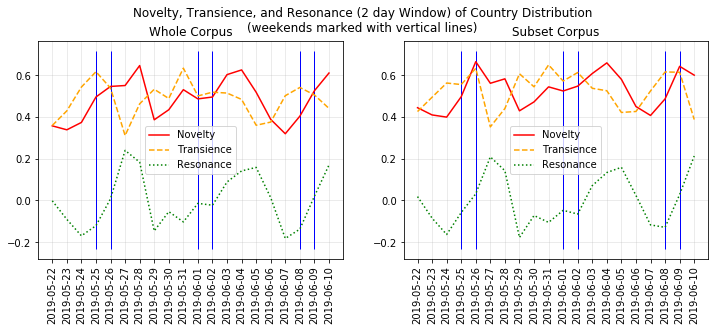

In [24]:
def create_smoothing_dist(val_counts):
    """Returns a distribution suitable for smoothing samples"""
    num_distinct = len(val_counts)
    old_total = val_counts.sum()
    new_total = num_distinct / 2
    return val_counts * new_total / old_total

all_dates = group_by_fields(whole_corpus_df, "Date").index

window_size = 2
some_dates = all_dates[window_size:-window_size]
weekends = some_dates[some_dates.strftime("%A").isin(["Saturday", "Sunday"])]

def smoothed_date_matrix(data, field):
    counts_by_field = group_by_fields(data, field)
    smoothing_dist = create_smoothing_dist(counts_by_field)
    smoothing_dist.reset_index(inplace=True)
    
    counts_by_date_and_field = group_by_fields(subset_corpus_df, "Date", field)
    counts_by_date_and_field.reset_index(inplace=True)
    for date in all_dates:
        smoothing_dist["Date"] = date
        counts_by_date_and_field = pd.concat([counts_by_date_and_field, smoothing_dist])
        
    return create_date_matrix(counts_by_date_and_field, field)

min_y = np.inf
max_y = -np.inf
def create_ntr_subplot(data, title, ax):
    smoothed_data = smoothed_date_matrix(data, "Country")
    novelty, transience, resonance = pyrocs_info.novelty_transience_resonance(smoothed_data, window_size)
    ax.plot(some_dates, novelty, label="Novelty", color="red")
    ax.plot(some_dates, transience, label="Transience", color="orange", linestyle="--")
    ax.plot(some_dates, resonance, label="Resonance", color="green", linestyle=":")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.set_title(title)
    ax.tick_params('x', labelrotation=90)
    ax.grid(True, alpha=.3)
    ax.legend()
    
    # Find data range
    global min_y, max_y
    for sequence in (novelty, transience, resonance):
        min_y = min(min_y, min(sequence))
        max_y = max(max_y, max(sequence))
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Novelty, Transience, and Resonance (2 day Window) of Country Distribution\n(weekends marked with vertical lines)", y=1)
create_ntr_subplot(whole_corpus_df, "Whole Corpus", ax1)
create_ntr_subplot(subset_corpus_df, "Subset Corpus", ax2)
for ax in ax1, ax2:
    ax.vlines(weekends, min_y - .05, max_y + .05, color='blue', linestyle='-', lw=1)
plt.show()

We can see that the NTR metrics have a strong weekly trend that is similar between the whole corpus and the subset corpus. For the whole corpus, Novelty tends to peak around Tuesdays (i.e., that's when new information often is introduced), and Transience tends to peak on Fridays or Saturdays (i.e., that's when information is relatively new compared to future information). Novelty and Transience mostly follow the same trend in the subset corpus, and interestingly, the shape of the resonance function is almost exactly the same between the whole and subset corpera. However, there is more variability in the timing of peaks within the subset, with novelty peaking on Sunday in some weeks and on Tuesday in others.

### Affinity
Affinity is a measure of correlation between two boolean variables. It can be any real number (and may be infinite or undefined in many cases). Our implementation takes a dataframe or matrix of booleans, with an optional 'weights' column.

In [28]:
def calc_affinity(data, country, language, corpus_name, print_=True):
    for_affinity = pd.concat([data["Country"]==country, data["Language"]==language], axis=1)
    affinity = pyrocs_bio.affinity(for_affinity, weights=data["Count"])["Country"]["Language"]
    if print_:
        print("Affinity between", country, "and", language, "for", corpus_name, "=\n", round(affinity,3))
    return affinity
    
affinity = calc_affinity(whole_corpus_df, "China", "Chinese", "Whole Corpus")

Affinity between China and Chinese for Whole Corpus =
 5.758


The data shows a strong affinity between an article being from China and being in Chinese. This is analogous to saying that there is an 18x likelihood of these two factors occurring together rather than occurring separately. To demonstrate this, we create a temporary dataset with these likelihoods and route them through the affinity function: 

In [30]:
temp_data = np.array([[1, 1],[1, 0],[0, 1],[0, 0]])
weights = np.array([18, 1, 1, 18])
affinity = pyrocs_bio.affinity(temp_data, weights=weights)[0][1]
print(round(affinity,3))

5.781


### Fluctuation Complexity
Fluctuation Complexity measures the extent to which high and low probability events mix in a sequence. Specifically it is defined as the mean squared difference between the surprisal (i.e., log probability) of adjacent events. To demonstrate this metric we need to create sequences of values even though this data only resolves time at the date level. We can simulate sequences by random sampling from each single date distribution (in this case, the result approximates varentropy).

We use the above technique to calculate Fluctuation Complexity of the country of origin for the articles in two ways.
1. Calculate the Fluctuation Complexity seperately for each date, and then average across days, weighting by number of articles
2. Compute Fluctuation Complexity on a single sequence concatinated from single date samples.

In [33]:
def sample_all_dates(data, field, sampling_factor=2):
    data = group_by_fields(data, field, "Date", reset_index=True)
    for date in all_dates:
        date_data = data[data["Date"] == date]
        date_count = date_data["Count"].sum()
        num_samples = round(date_count * sampling_factor)
        sample = date_data[field].sample(
            num_samples,
            replace=True,
            weights=date_data["Count"],
            random_state=12345)
        yield sample
        
whole_country_date_samples = list(sample_all_dates(whole_corpus_df, "Country"))
subset_country_date_samples = list(sample_all_dates(subset_corpus_df, "Country"))

def fc_weighted_mean(date_samples):
    per_date_fc = [pyrocs_cmpx.fluctuation_complexity(s) for s in date_samples]
    weights = [len(s) for s in date_samples]
    return np.average(per_date_fc, weights=weights)

def fc_concatinated(date_samples):
    concatinated = []
    for sample in date_samples:
        concatinated.extend(sample)
    return pyrocs_cmpx.fluctuation_complexity(concatinated)

print("Fluctuation Complexity - Weighted Mean of Dates")
print("Whole Corpus:", round(fc_weighted_mean(whole_country_date_samples),3))
print("Subset Corpus:", round(fc_weighted_mean(subset_country_date_samples),3))

print("\nFluctuation Complexity - Concatinated Samples")
print("Whole Corpus:", round(fc_concatinated(whole_country_date_samples),3))
print("Subset Corpus:", round(fc_concatinated(subset_country_date_samples),3))

Fluctuation Complexity - Weighted Mean of Dates
Whole Corpus: 6.679
Subset Corpus: 3.955

Fluctuation Complexity - Concatinated Samples
Whole Corpus: 6.65
Subset Corpus: 5.506


For both methods, the fluctuation complexity of the subset corpus is significantly less than for the whole corpus. This means that the subset corpus has a more uniform country distribution. Interestingly, the subset corpus shows a significant difference between the two methods, whereas for the whole corpus, they produce nearly the same value. These results reflect the greater variation between days in the subset corpus, despite the country distributions being more uniform when focusing on single days.

### Global Reaching Centrality
The **Global Reaching Centrality (GRC)** of a graph measures how much different nodes vary in "centralness", with a value of 0 meaning that all nodes are equally "central" to the graph. GRC is defined differently for directed and undirected graphs. For an undirected/unweighted graph, the "centralness" of a given node (or more formally, the "Local Reaching Centrality") is defined as the sum of inverse graph distances to all other (reachable) nodes.

We can use GRC to understand relationships between countries, such as (in the space of languages), if there is one country that is particularly close to all others, or if countries tend to be equally distant from each other. To compute GRC, we take the following steps:
1. Find distances between countries in space of language distributions (this analysis uses total variation distance)
2. Set a distance threshold in (0, 1). Countries closer than this threshold are considered adjacent in a graph.
3. Use pyRoCS to compute the Global Reaching Centrality of the graph

Rather than use a single threshold, let's sweep the threshold from 0 to 1, and view GRC as a function of threshold for both corpora.

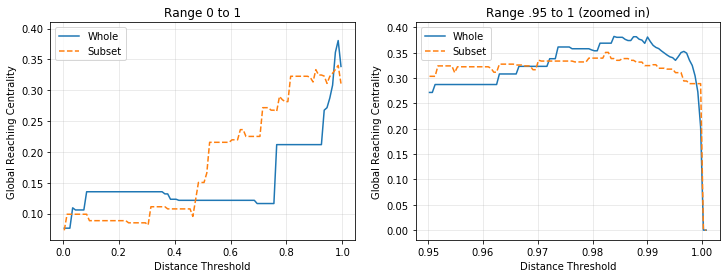

In [34]:
def top_values(data, size=10, field="Country"):
    grouped = group_by_fields(data, field).sort_values("Count", ascending=False)
    return grouped.head(size).index

def make_distance_matrix(
        data,
        labels,
        label_field="Country",
        second_field="Language"):
    second_field_values = group_by_fields(data, second_field).index
        
    # Get distributions for all row labels
    distributions = []
    for label in labels:
        filtered_data = data[data[label_field] == label]
        grouped_data = group_by_fields(filtered_data, second_field)
        array = second_field_values.map(
            lambda x: grouped_data["Count"].get(x, 0)
        ).to_numpy(dtype=float)
        array = array / array.sum()
        distributions.append(array)

    result_size = len(labels)
    result = np.zeros((result_size, result_size), float)
    for i in range(result_size):
        distr_i = distributions[i]
        for j in range(i):
            distr_j = distributions[j]
            distance = min(np.linalg.norm(distr_i - distr_j, ord=1) / 2, 1)
            result.itemset((i, j), distance)
            result.itemset((j, i), distance)
    return result

def grc_from_distances(distances, threshold):
    adjacency_matrix = np.where(distances < threshold, 1, 0)
    return pyrocs_cmpx.grc(adjacency_matrix, directed=False)

NUM_COUNTRIES = 25
top_whole_countries = top_values(whole_corpus_df, size=NUM_COUNTRIES)
top_subset_countries = top_values(subset_corpus_df, size=NUM_COUNTRIES)

whole_distances = make_distance_matrix(whole_corpus_df, labels=top_whole_countries)
subset_distances = make_distance_matrix(subset_corpus_df, labels=top_subset_countries)

def graph_grc(ax, lower_bound, upper_bound, num_thresholds, title=""):
    k = (upper_bound - lower_bound) / num_thresholds
    min_threshold = lower_bound + (k / 2)
    thresholds = [i*k + min_threshold for i in range(num_thresholds)]
    whole_grc_values = [grc_from_distances(whole_distances, t) for t in thresholds]
    subset_grc_values = [grc_from_distances(subset_distances, t) for t in thresholds]
    ax.plot(thresholds, whole_grc_values, label="Whole", linestyle="-")
    ax.plot(thresholds, subset_grc_values, label="Subset", linestyle="--")
    ax.set_title(title)
    ax.set_xlabel("Distance Threshold")
    ax.set_ylabel("Global Reaching Centrality")
    ax.set_ybound(upper=.41)
    ax.grid(True, alpha=.3)
    ax.legend()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
graph_grc(ax1, 0, 1, 100, "Range 0 to 1")
graph_grc(ax2, .95, 1.001, 100, "Range .95 to 1 (zoomed in)")
plt.show()

For most of the valid threshold range (0 to 1), we see an overall trend of increasing GRC with increasing threshold, and therefore increasing connectedness. When the threshold reaches 1, all nodes are connected, and the GRC plummets back to 0. Both corpera have their maximum GRC between .98 and 1. The GRC graphs also reveal multiple large jumps indicating structural changes within the graph. Interestingly, the jumps from the subset corpus GRC seem to mirror those from the whole corpus, but with a lateral shift. 

To better understand these jumps, we visualize the graphs themselves. The plots below show with thresholds set to barely include two of the largest jumps that seem to mirror each other: around 0.78 for the whole corpus, and 0.48 for the subset corpus. The plots also highlight the connections formed near those thresholds.

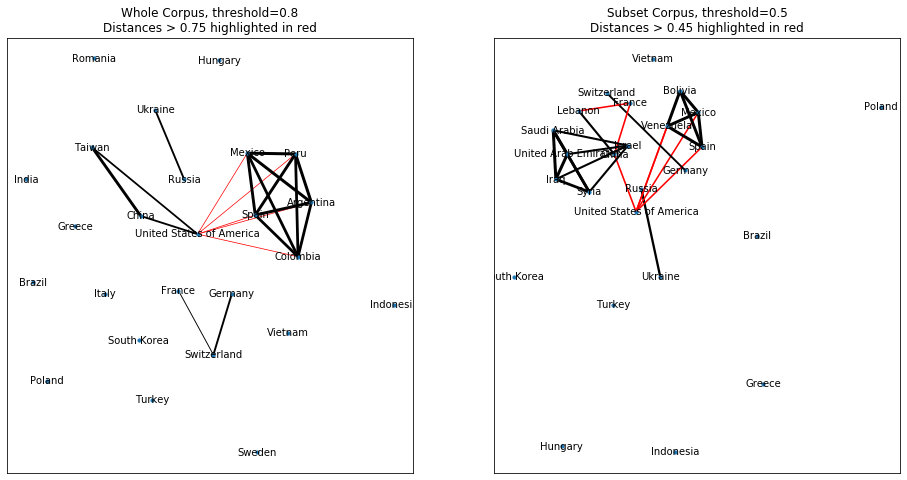

In [37]:
import networkx as nx
import math

def color_by_dist(weight, threshold):
    if weight > threshold:
        return "black"
    else:
        return "black"
    
def draw_graph(ax, distances, labels, threshold, highlight, title):
    ax.set_title(title.format(threshold=threshold, highlight=highlight))
    power = 4
    weights = (1 - distances)**(1/power)
    threshold = (1 - threshold)**(1/power)
    highlight = (1 - highlight)**(1/power)
    # get positions
    graph = nx.Graph(weights)
    graph.remove_edges_from(list(nx.selfloop_edges(graph)))
    pos = nx.spring_layout(graph, seed=1)
    edges = graph.edges()
    weight_list = [graph[u][v]['weight'] for u,v in edges]
    colors = ["black" if w >= highlight else "red" for w in weight_list]
    widths = [3*w**power if w > threshold else 0 for w in weight_list]
    
    labels = dict(zip(graph.nodes(), labels))
    nx.draw_networkx(graph, pos, width=widths, node_size=10, edge_color=colors, ax=ax, labels=labels, font_size=10)
    
title_sfx = ", threshold={threshold}\nDistances > {highlight} highlighted in red"
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
draw_graph(ax1, whole_distances, top_whole_countries, .8, .75, "Whole Corpus" + title_sfx)
draw_graph(ax2, subset_distances, top_subset_countries, .5, .45, "Subset Corpus" + title_sfx)
plt.show()

These visualizations provide insights into the existing networks within the two corpora. For example, the whole corpus has a network of Spanish-speaking countries (pentagram) as well as some relationships between Chinese, Russian, and Swiss speaking nations. In contrast, the subset corpus has an additional network of Arabic speaking nations (i.e., kite shape) that is not present within the whole corpus. 

These variations are also present in the jumps (visualized in red) where bonds are present between the Spanish-speaking countries with the United States in both corpora. The subset shows an additional set of bonds between Lebanon, France, and other nations as well. GRC helped us to discover this important similar step in the evolution of both graphs.